# Sinkhorn in all flavors

We provide in this example a walk-through of some of the functionalities of the ``sinkhorn`` algorithm, notably parallel computation of ``sinkhorn_divergence`` and elementary tuning of ``sinkhorn`` parameters such as ``epsilon`` or ``momentum_strategy``. This tutorial is the abridged version of the following [colab](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi#scrollTo=zsekRny9wZoI), which has all you need to recreate all plots below.

In [ ]:
import ott
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.core.sinkhorn import sinkhorn
from ott.geometry.pointcloud import PointCloud

## From Texts to Word Histograms


We adapt a [keras NLP tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/) to preprocess raw text (here a subset of texts from the [newsgroup20](https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html) database) and turn them into word embeddings histograms.

In [ ]:
data_path = tf.keras.utils.get_file(
    "mini_newsgroups.tar.gz",
    "https://kdd.ics.uci.edu/databases/20newsgroups/mini_newsgroups.tar.gz",
    untar=True,
)

Load a small subset of $2$ texts for each of the $20$ classes for a total of $40$ texts, removing headers.

In [ ]:
import os
import pathlib
data_dir = pathlib.Path(data_path).parent / "mini_newsgroups"
dirnames = os.listdir(data_dir)
fnames = os.listdir(data_dir / "comp.graphics")
samples = []
class_names = []
for dirname in sorted(os.listdir(data_dir)):
  class_names.append(dirname)
  dirpath = data_dir / dirname
  fnames = os.listdir(dirpath)
  print("Processing %s" % dirname)
  per_class = 0
  for fname, _ in zip(fnames, range(2)): # here the range 2 makes the loop stop after 2 texts per class.
    with open (dirpath / fname, encoding='latin-1') as fp:
      samples.append("".join(fp.readlines()[:-1]))
N=len(samples)
print("Total Number of texts:", N)

Most of the texts have a length that concentrates around $1,000$ as shown below, none exceeds $10,000$ words. We'll use that to cap all lengths.

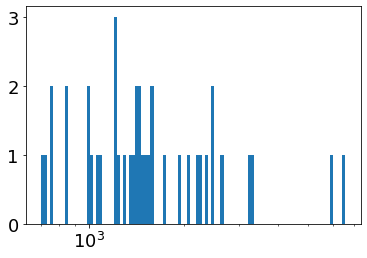

In [ ]:
# Plot histogram of text lengths.

Use `tf.keras` code to parse these texts, create a vocabulary index, and map texts onto histograms on that vocabulary.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=10000)
text_ds = tf.data.Dataset.from_tensor_slices(samples).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


Download pre-trained Word embeddings, here selected to have a smallish dimension of 50.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

Out of those hundreds of thousands of vectors, extract those appearing in our vocabulary.

In [ ]:
dim = 50
embeddings_index = {}
with open("glove.6B." + str(dim) +"d.txt") as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0
max_norm = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
embedding_exists = np.zeros((num_tokens,), dtype=bool)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    max_norm = max(np.sum(embedding_vector ** 2), max_norm)
    hits += 1
    embedding_exists[i] = True
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

# Normalize Vectors to have maximal norm 1.
embedding_matrix /= np.sqrt(max_norm)

Found 400000 word vectors.
Converted 2431 words (587 misses)


We can now recover $N$ histograms of size $2431$ (the total number of words in the vocabulary above) that have embeddings. These histograms are relatively sparse. The function is `text_to_embeddings` is defined in the full [colab](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi#scrollTo=zsekRny9wZoI).

In [ ]:
HIST = texts_to_embedding_measures(samples) # Histograms
X = jnp.array(tf.boolean_mask(embedding_matrix, embedding_exists, axis=0)) # embeddings for all words.

## Pairwise Sinkhorn Divergences

We start by defining a `jitted` version of the `sinkhorn_divergence` using a double `vmap` to compute in one go the pairwise *matrix* of sinkhorn divergence between two sets of histograms. Jitting is super important to achieve efficiency, don't forget to wrap whatever you to with a `jax.jit` if you want to run at scale.

In [ ]:
sink_div = jax.jit(jax.vmap(
    lambda HIST_1, HIST_2, X, epsilon: jax.vmap(
        lambda hist_1, hist_2, X, epsilon : sinkhorn_divergence(
            PointCloud, X, X, epsilon=epsilon, a=hist_1, b=hist_2).divergence,
        in_axes=[0, None, None, None])(HIST_1, HIST_2, X, epsilon),
    in_axes=[None, 0, None,None]))

Before setting a value for `epsilon`, let's get a feel of what the point cloud of embeddings looks like in terms of distances.

In [ ]:
geom = PointCloud(X,X). # geometry of a point cloud compared to itself.
print('median:', geom.median_cost_matrix, ' mean:', geom.mean_cost_matrix, ' max:', jnp.max(geom.cost_matrix))

median: 0.6983606  mean: 0.7092886  max: 2.2600524


When setting `epsilon` to `None`, the algorithms will default to 1/20th of the mean distance, namely

In [ ]:
print('Default epsilon is: ', geom.epsilon)

Default epsilon is:  0.035464432


Let's now compute a pairwise $20 \times 20$ matrix of Sinkhorn divergences. We first divide the set of texts in 2 blocks of 20 each.

In [ ]:
HIST_a = jnp.array(HIST[0:20])
HIST_b = jnp.array(HIST[20:])

Launch a "dry" run with large epsilon value to force jit compilation so that timings reported below are not impacted by pre-compilation.

In [ ]:
DIV = sink_div(HIST_a, HIST_b, X, 1000)

We now carry out the computation of 4 pairwise divergence matrices, one for a different `epsilon` values.

In [ ]:
DIV, ran_in = [] , []
epsilons = [None, 5e-2, 1e-1, 1]
for epsilon in epsilons:  
  tic = time.perf_counter()
  DIV.append(sink_div(HIST_a, HIST_b, X, epsilon).block_until_ready())
  toc = time.perf_counter()
  ran_in.append(toc - tic)

By looking at the 4 divergence matrices (one for each value of `epsilon`) we can see that `epsilon` impacts directly computational speed, but provides divergence values that seem comparable (relative to each other).

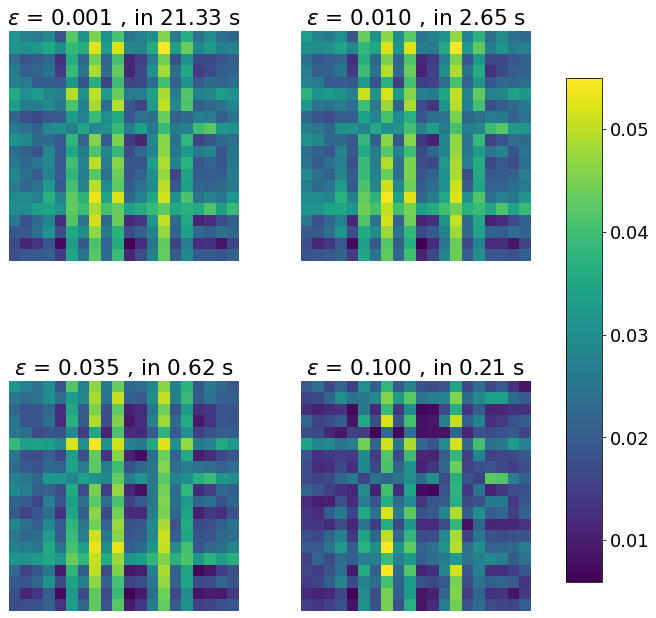

In [ ]:
# Plot these 4 matrices

## $\varepsilon$ and momentum

We study in more detail how `epsilon` impacts the convergence of the algorithm. We create a (jitted) handle for the resolution of a single `sinkhorn` call between two histograms.

In [ ]:
sinkorn_fun = jax.jit(
    lambda a, b, X, epsilon : sinkhorn(
        PointCloud(X, X, epsilon=epsilon),
        inner_iterations=1, # recomputing error every iteration for plots.
        a=a, b=b))

a, b = HIST_a[0], HIST_b[-1]
# Another dry run to force jit compilation.
_ = sinkorn_fun(a, b, X, 1000)

Using the first and last histogram of each respective set, let's take a closer look at the output of `sinkhorn` for various `epsilon` values, notably that selected by default:

In [ ]:
out_eps , leg_eps = [], []
epsilons = [1e-3, 1e-2, None, 1e-1, 1]
ran_in = np.zeros((len(epsilons),))
for i, eps in enumerate(epsilons):
  tic = time.perf_counter()  
  out_eps.append(sinkorn_fun(a, b, X, eps))
  toc = time.perf_counter()
  ran_in[i] = toc - tic  
  leg_eps.append(r'$\varepsilon$' + f'= {eps}, cost = {out_eps[-1].reg_ot_cost:.2f}')

These execution times can then be plotted, to result in the following graph.

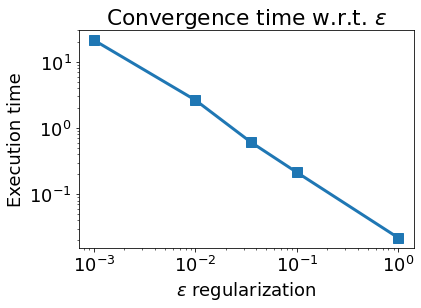

In [ ]:
# Plot convergence depending on `epsilon` value

The convergence is greatly impacted by `epsilon`, there is therefore a tradeoff between speed and how close to the original Wasserstein you want to be. The former is evident, the latter depends on your problem. If you have no strong opinion on how to set ``epsilon``, larger `epsilon` values are a sure bet since this makes your life substantially easier.

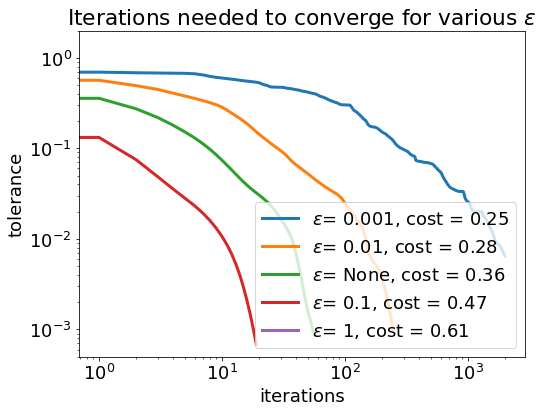

In [ ]:
plot_results(out_eps, leg_eps, title=r'Iterations needed to converge for various $\varepsilon$', xlabel='iterations', ylabel='tolerance')

[Thibault et al.](https://arxiv.org/abs/1711.01851) proposed to use a momentum term to accelerate the convergence of the Sinkhorn algorithm. This can be used by modifying the `momentum_strategy` parameter. We test various values here in the setting where `epsilon` is small. The `lehmann` heuristic proposes an adaptive way to set that value automatically after a few Sinkhorn iterations (as can be seen in this [paper](https://arxiv.org/pdf/2012.12562v1.pdf))

In [ ]:
out_mom , leg_mom = [], []
for mom in [.5, .8, 1.0, 1.1, 1.3, 'lehmann']:  
  out_mom.append(sinkhorn(PointCloud(X, X, epsilon=1e-3),
                          inner_iterations=1, momentum_strategy=mom,
                          a=a, b=b, jit=True))            
  leg_mom.append(f'Momentum : {mom}')

As can be seen below, using a momentum value larger than 1.0 (also known as extrapolation or overrelaxation) can accelerate substantially the convergence. When in doubt, a possible approach is to use an adaptive rule that runs for a few iterations to estimate then a useful momentum term, as shown here with the `lehmann` heuristic.

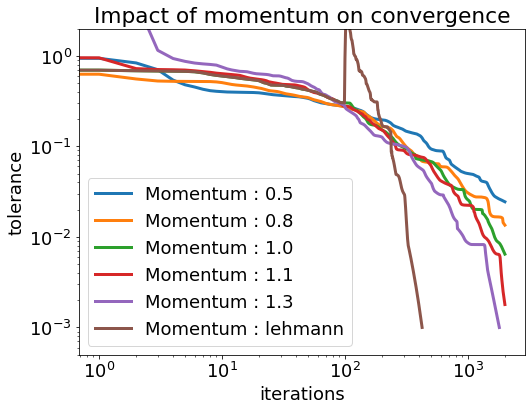

In [ ]:
plot_results(out_mom, leg_mom, 'lower left', title = 'Impact of momentum on convergence', xlabel='iterations', ylabel='tolerance')